## Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os

## Reading train labels

In [2]:
df_train = pd.read_csv('Dataset/Fall/train_labels.csv', index_col='images')
df_train

,labels
images,
fall-02-cam1-rgb-001.jpg,0
fall-02-cam1-rgb-002.jpg,0
fall-02-cam1-rgb-003.jpg,0
fall-02-cam1-rgb-004.jpg,0
fall-02-cam1-rgb-005.jpg,0
...,...
fall-11-cam1-rgb-126.jpg,1
fall-11-cam1-rgb-127.jpg,1
fall-11-cam1-rgb-128.jpg,1


## Reading test labels

In [3]:
test_df = pd.read_csv('Dataset/Fall/test_labels.csv', index_col='images')
test_df

,labels
images,
fall-03-cam1-rgb-077.jpg,0
fall-03-cam1-rgb-093.jpg,0
fall-03-cam1-rgb-178.jpg,1
fall-03-cam1-rgb-196.jpg,1
fall-04-cam1-rgb-005.jpg,0
fall-04-cam1-rgb-042.jpg,1
fall-04-cam1-rgb-057.jpg,1
fall-17-cam1-rgb-068.jpg,1
fall-17-cam1-rgb-094.jpg,1


In [5]:
# reading train and test images from the folder and stacking them while keep tracking of corresponding labels
dataset_folder = 'Dataset/Fall'
train_images = []
train_labels = []
test_images = []
test_labels = []

for folder in os.listdir(dataset_folder):
    folder_path = os.path.join(dataset_folder, folder)
    if folder == 'train_images':
        for file in os.listdir(folder_path):
            if file.endswith('jpg'):
                img_path = os.path.join(folder_path, file)
                img = cv2.imread(img_path)
                train_images.append(img)
                train_labels.append(df_train.loc[file, 'labels'])
    
    elif folder == 'test_images':
        for file in os.listdir(folder_path):
            if file.endswith('jpg'):
                img_path = os.path.join(folder_path, file)
                img = cv2.imread(img_path)
                test_images.append(img)
                test_labels.append(test_df.loc[file, 'labels'])
    else:
        pass
            
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)
print('Shape of stacked train images:', train_images.shape)
print('Shape of train labels:', train_labels.shape)
print('Shape of stacked test images:', test_images.shape)
print('Shape of test labels:', test_labels.shape)

Shape of stacked train images: (240, 96, 96, 3)
Shape of train labels: (240,)
Shape of stacked test images: (12, 96, 96, 3)
Shape of test labels: (12,)


## Visualizing some images together with their label to have an idea about our data

In [6]:
# Function to convert binary label into text
def get_label(num):
    if num == 0:
        return 'NOT FALL'
    if num == 1:
        return 'FALL'
    else:
        return -1

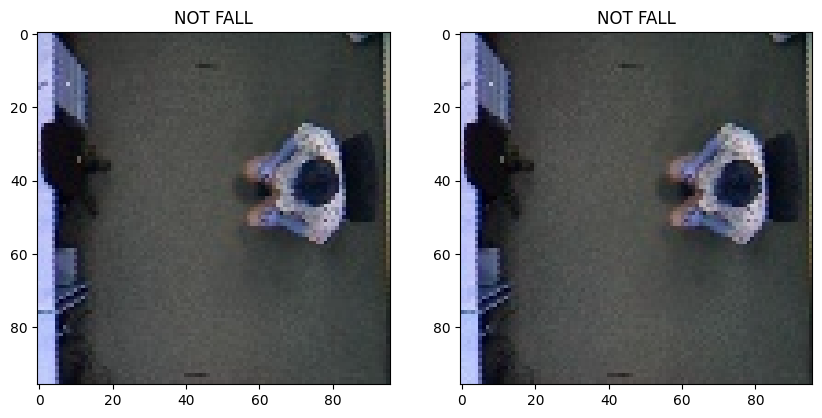

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 8), squeeze=False)
axes[0][0].imshow(train_images[2])
axes[0][0].set_title(get_label(train_labels[2]))

axes[0][1].imshow(train_images[3])
axes[0][1].set_title(get_label(train_labels[3]));

## Splitting our data into train and validation sets, building and training our model

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, stratify=train_labels, test_size=0.2)

In [9]:
X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255

In [10]:
w, h = 96 , 96 
X_train = X_train.reshape(X_train.shape[0],w,h,3)
X_ = X_val.reshape(X_val.shape[0],w,h,3)

In [11]:
def conv2d(filters: int, name):
    return Conv2D(filters=filters, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.), bias_regularizer=l2(0.), name=name)

In [12]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, ReLU
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.regularizers import l2

# fallnet architecture
model_input = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]), name='inputs')

conv1 = conv2d(16, name='convoluton_1')(model_input)
act1 = ReLU(name='activation_1')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2), name='pooling_1')(act1)

conv2 = conv2d(16, name='convolution_2')(pool1)
act2 = ReLU(name='activation_2')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2), name='pooling_2')(act2)

conv3 = conv2d(32, name='convolution_3')(pool2)
act3 = ReLU(name='activation_3')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2), name='pooling_3')(act3)

conv4 = conv2d(32, name='convolution_4')(pool3)
act4 = ReLU(name='activation_4')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2), name='pooling_4')(act4)

conv5 = conv2d(64, name='convolition_5')(pool4)
act5 = ReLU(name='activation_5')(conv5)
pool5 = MaxPooling2D(pool_size=(2, 2), name='pooling_5')(act5)

conv6 = conv2d(64, name='convolution_6')(pool5)
act6 = ReLU(name='activation_6')(conv6)
pool6 = MaxPooling2D(pool_size=(2, 2), name='pooling_6')(act6)

flat = Flatten(name='flatten')(pool6)
dense1 = Dense(32, name='dense1')(flat)
output = Dense(1, activation='sigmoid', name='output')(dense1)

model = Model(inputs=[model_input], outputs=[output])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 96, 96, 3)]       0         
                                                                 
 convoluton_1 (Conv2D)       (None, 96, 96, 16)        448       
                                                                 
 activation_1 (ReLU)         (None, 96, 96, 16)        0         
                                                                 
 pooling_1 (MaxPooling2D)    (None, 48, 48, 16)        0         
                                                                 
 convolution_2 (Conv2D)      (None, 48, 48, 16)        2320      
                                                                 
 activation_2 (ReLU)         (None, 48, 48, 16)        0         
                                                                 
 pooling_2 (MaxPooling2D)    (None, 24, 24, 16)        0     

### Visualizing out CNN Arhitecture with visualkeras Library

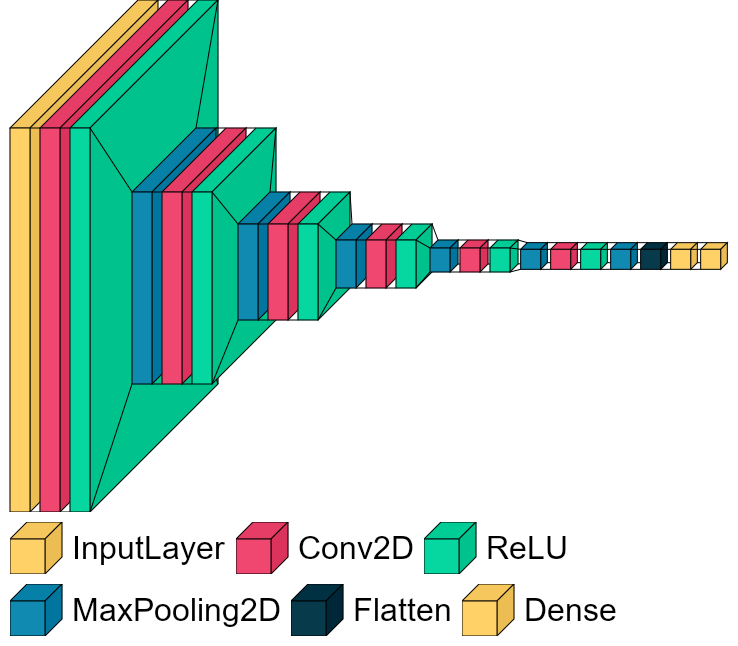

In [13]:
import visualkeras
from PIL import ImageFont

font = ImageFont.truetype("arial.ttf", 32) 
visualkeras.layered_view(model, legend=True, font=font, to_file='fallnet_architecture.png') 

In [14]:
optimizer = tf.keras.optimizers.Adam(lr=0.001, epsilon=1e-08, decay=0.0)
import keras.backend as K
import tensorflow as tf
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())
def conditional_average_metric(y_true, y_pred):
    spec = specificity(y_true, y_pred)
    sens = sensitivity(y_true, y_pred)

    minimum = K.minimum(spec, sens)
    condition = K.less(minimum, 0.5)

    multiplier = 0.001
    # This is the constant used to substantially lower
    # the final value of the metric and it can be set to any value
    # but it is recommended to be much lower than 0.5

    result_greater = 0.5 * (spec + sens)
    result_lower = multiplier * (spec + sens)
    result = K.switch(condition, result_lower, result_greater)

    return result
def sensitivity(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())
def F1_Score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
metrics=[tf.keras.metrics.AUC(num_thresholds=200,curve='ROC',summation_method='interpolation',name=None,dtype=None,thresholds=None,multi_label=False,num_labels=None,label_weights=None,from_logits=False),
                         tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),'accuracy',
                   specificity,conditional_average_metric ,sensitivity,F1_Score]

C:\Users\haider computer s\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [15]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='val_accuracy',
    restore_best_weights=True,
    verbose=1
)
from livelossplot.inputs.keras import PlotLossesCallback
from keras.callbacks import ModelCheckpoint
plot_loss_1 = PlotLossesCallback()

#ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='model.h5',
                                  save_best_only=True,
                                  verbose=1)

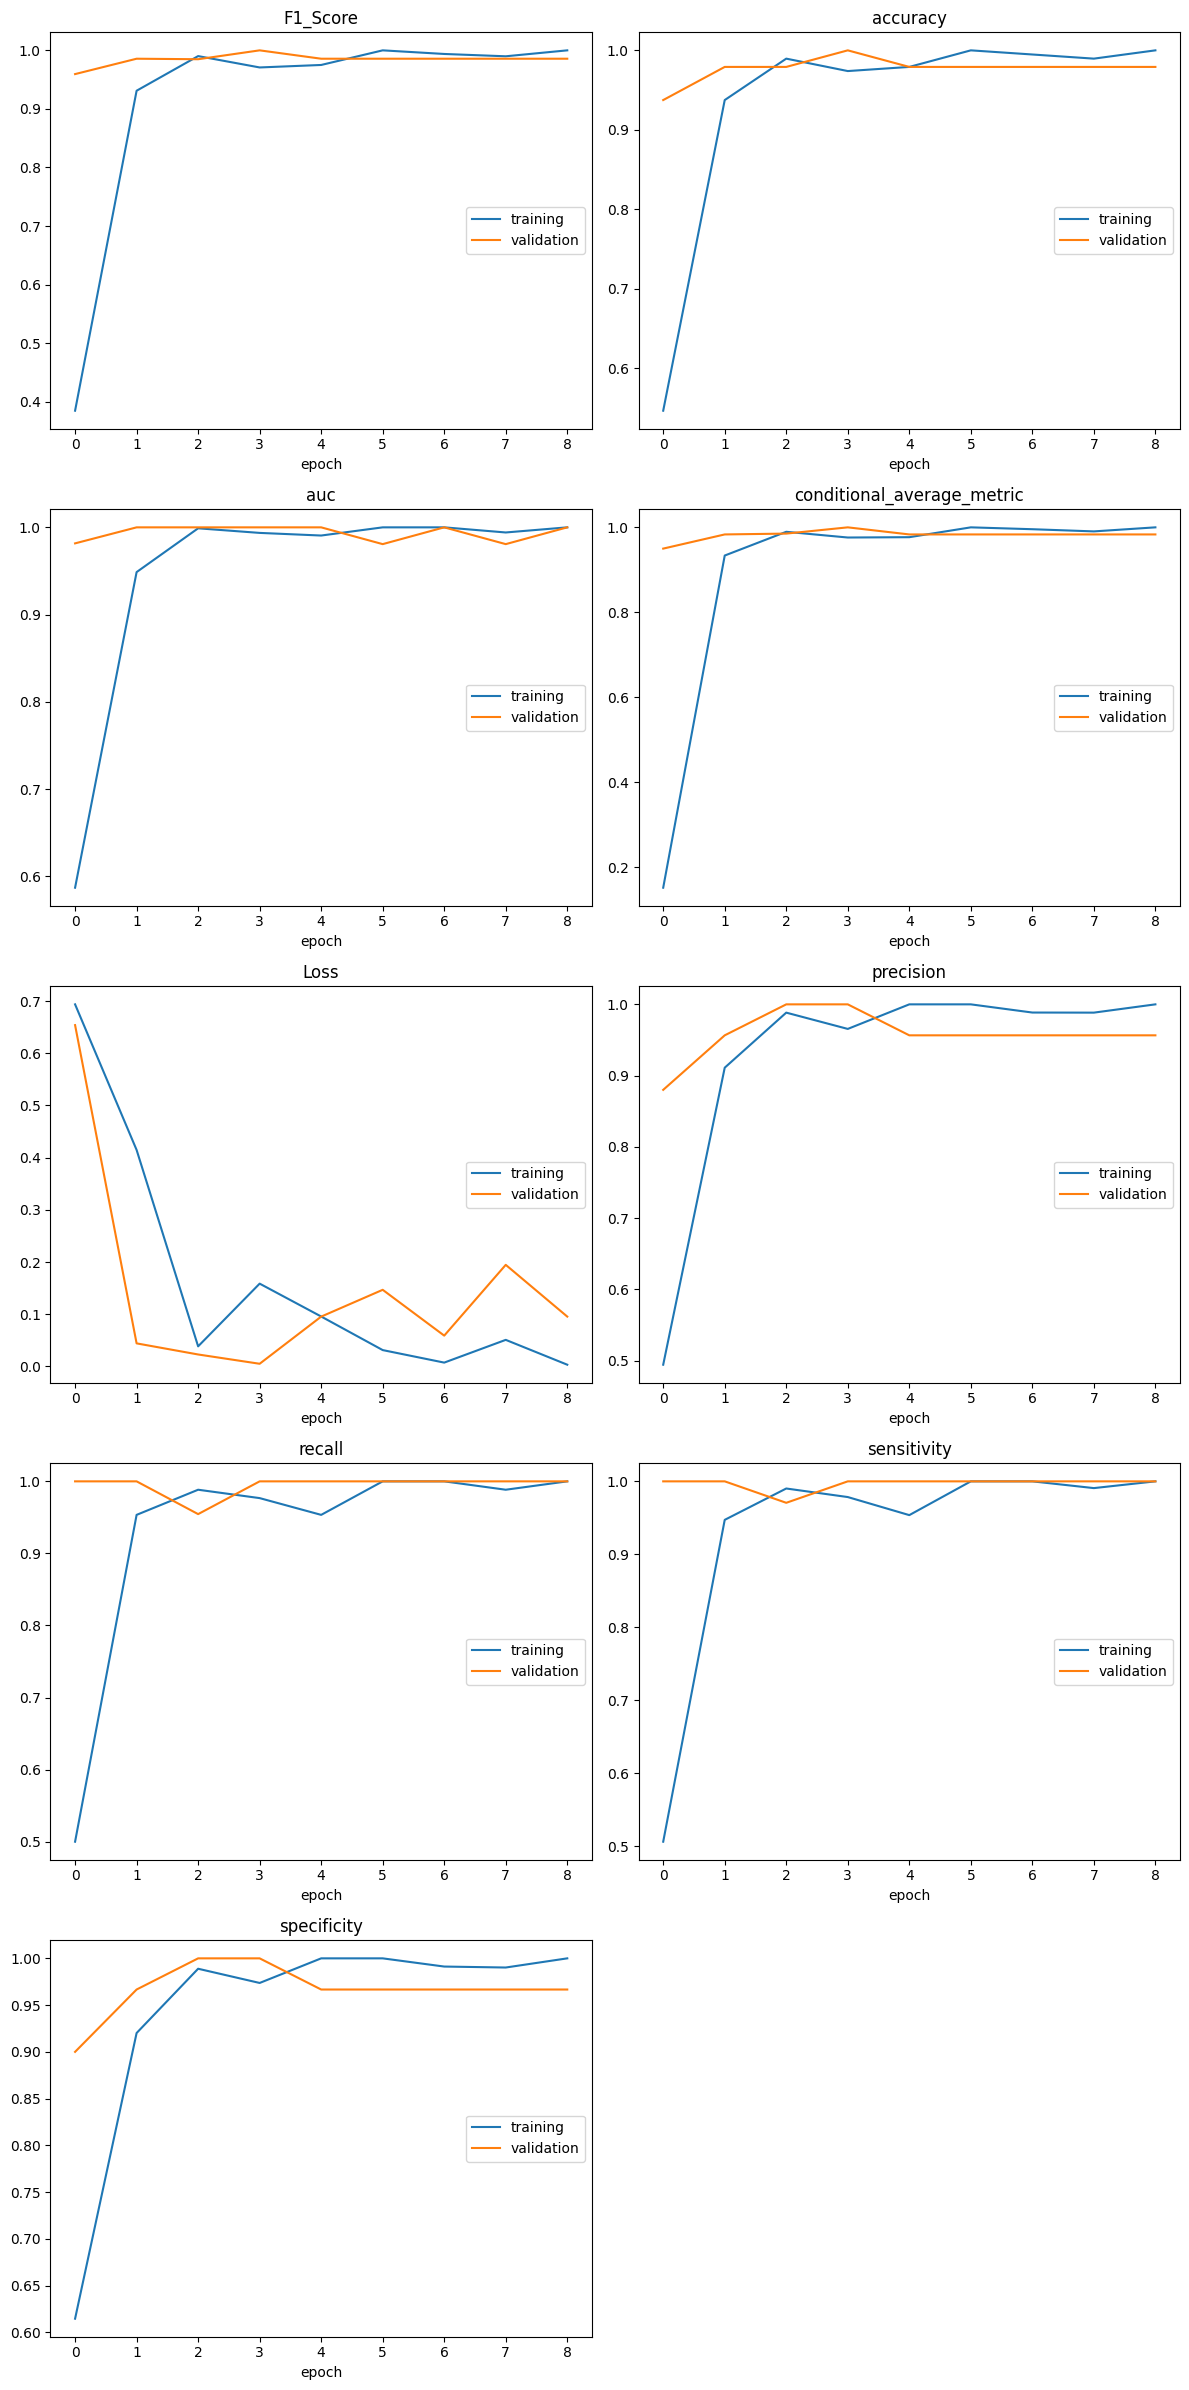

F1_Score
	training         	 (min:    0.385, max:    1.000, cur:    1.000)
	validation       	 (min:    0.959, max:    1.000, cur:    0.986)
accuracy
	training         	 (min:    0.547, max:    1.000, cur:    1.000)
	validation       	 (min:    0.938, max:    1.000, cur:    0.979)
auc
	training         	 (min:    0.587, max:    1.000, cur:    1.000)
	validation       	 (min:    0.981, max:    1.000, cur:    1.000)
conditional_average_metric
	training         	 (min:    0.152, max:    1.000, cur:    1.000)
	validation       	 (min:    0.950, max:    1.000, cur:    0.983)
Loss
	training         	 (min:    0.003, max:    0.694, cur:    0.003)
	validation       	 (min:    0.005, max:    0.654, cur:    0.095)
precision
	training         	 (min:    0.494, max:    1.000, cur:    1.000)
	validation       	 (min:    0.880, max:    1.000, cur:    0.957)
recall
	training         	 (min:    0.500, max:    1.000, cur:    1.000)
	validation       	 (min:    0.955, max:    1.000, cur:    1.000)
sensi

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.005), loss='binary_crossentropy', metrics=metrics)
history = model.fit(X_train,y_train, epochs = 200, validation_data = (X_val, y_val),callbacks=[
        early_stopping_callback,plot_loss_1,tl_checkpoint_1
    ])

## Testing our model

In [17]:
predicted_labels = (model.predict(test_images) >= 0.5).astype('int64').flatten()

1/1 [==============================] - 0s 198ms/step


In [18]:
89

89

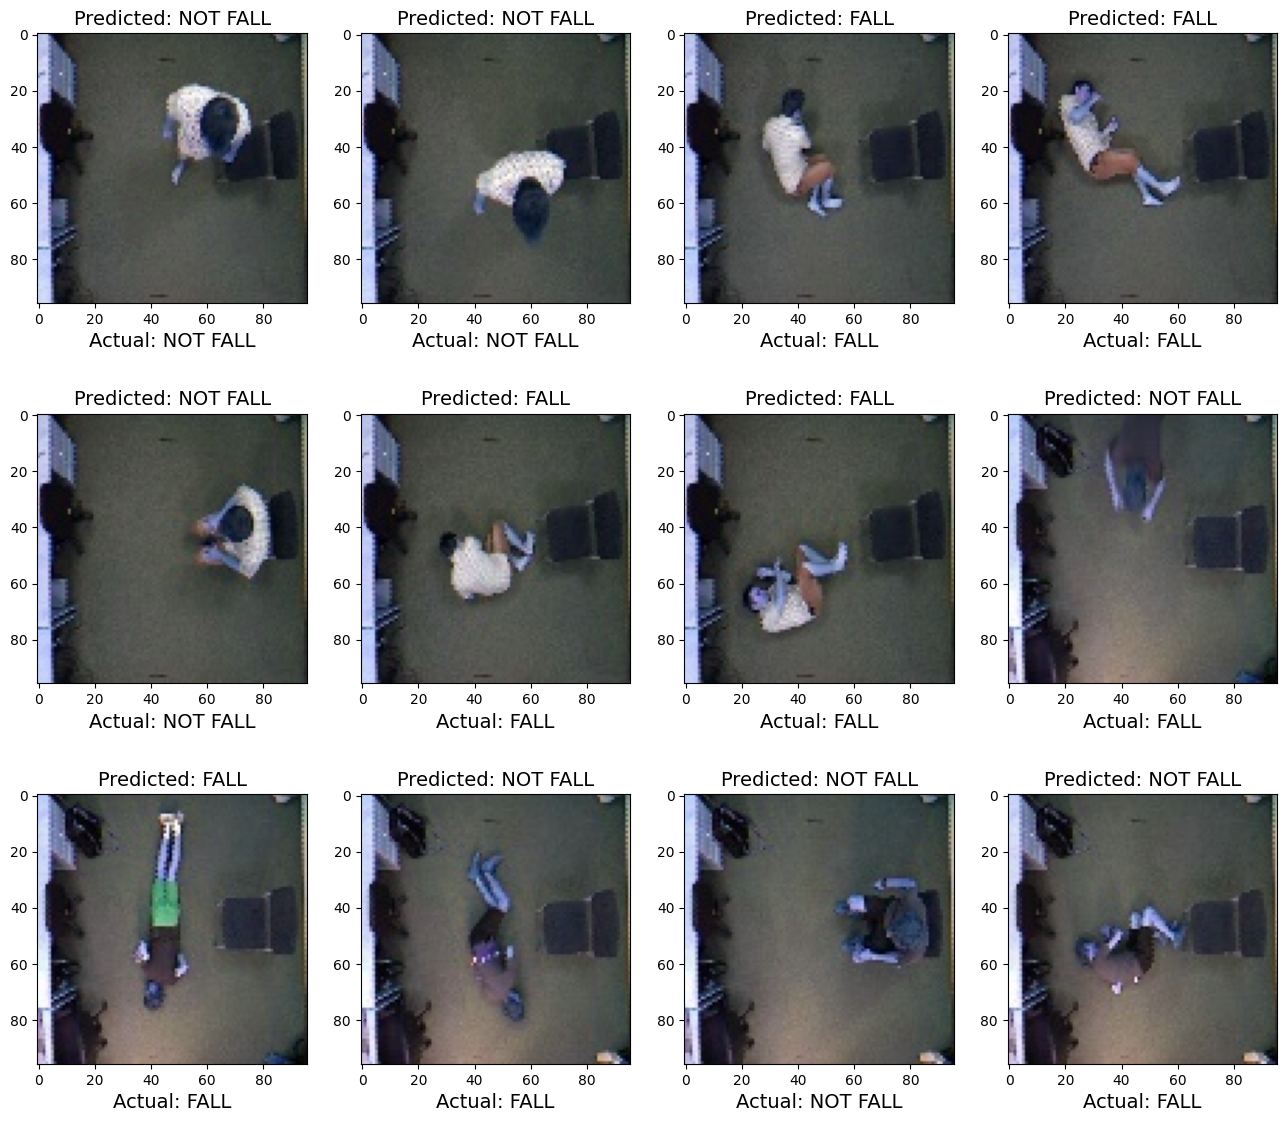

In [19]:
# visualizing our results
row = 3
col = 4
fig, axes = plt.subplots(row, col, figsize=(16, 14))
c = 0
for i in range(row):
    for j in range(col):
        axes[i][j].imshow(test_images[c])
        axes[i][j].set_title(f'Predicted: {get_label(predicted_labels[c])}', fontsize=14)
        axes[i][j].set_xlabel(f'Actual: {get_label(test_labels[c])}', fontsize=14)
        c += 1

## Model on unseen Data

Input image shape: (1, 96, 96, 3)
1/1 [==============================] - 0s 31ms/step
Fall predicted


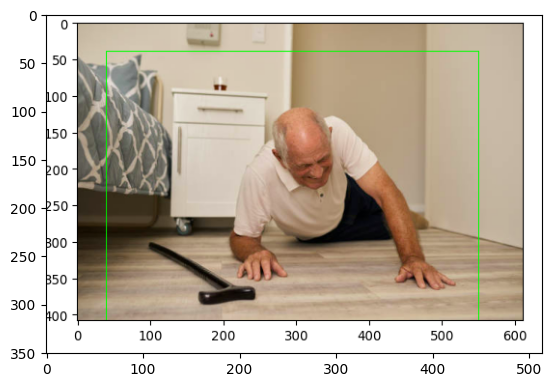

In [26]:
img_path = '10.png'


img = cv2.imread(img_path)
img = cv2.resize(img, (96, 96))

x = np.expand_dims(img, axis=0)
#x = preprocess_input(x)

print('Input image shape:', x.shape)
import cv2
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
my_image = imread(img_path)
imshow(my_image)



preds=model.predict(x)
if preds == 0:
    print("Fall predicted")
else:
    print("No Fall Predicted")


Input image shape: (1, 96, 96, 3)
1/1 [==============================] - 0s 24ms/step
Fall predicted


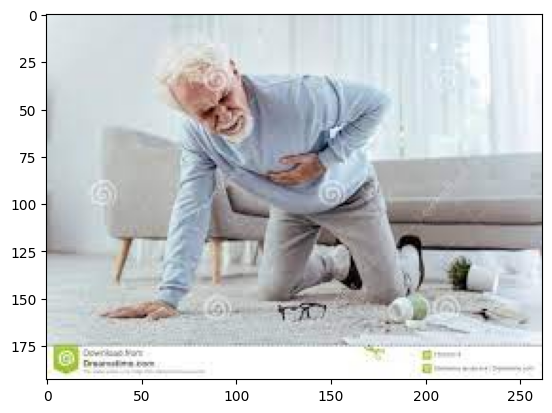

In [29]:
img_path = '11.jpeg'


img = cv2.imread(img_path)
img = cv2.resize(img, (96, 96))

x = np.expand_dims(img, axis=0)
#x = preprocess_input(x)

print('Input image shape:', x.shape)
import cv2
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
my_image = imread(img_path)
imshow(my_image)


preds=model.predict(x)
if preds == 0:
    print("Fall predicted")
else:
    print("No Fall Predicted")